# AmpliGraph Tutorial

This tutorial will guide you through the process of using AmpliGraph for knowledge graph embedding. We will cover the following topics:

1. Data Preparation
2. Creating SPO triples
3. Setting up Models
4. Evaluations

Before we start, make sure you have installed the AmpliGraph library. If not, you can install it by running `!pip install ampligraph` in a code cell.

In [1]:
import sys
sys.path.append('../..')
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
from ampligraph.utils import save_model, restore_model

## 1. Data Preparation

In this section, we will load and prepare our data. The data should be in a TSV (Tab-Separated Values) format. 

In [3]:
import pandas as pd

# Define the subjects, predicates, and objects
subjects =   ['Alice', 'Bob', 'Charlie', 'David', 'Eve', 'Alice', 'Bob', 'David', 'Eve', 'Frank', 'David']
predicates = ['like', 'like', 'like', 'like', 'like', 'has', 'has', 'has' , 'has','has', 'has']
objects =    ['movie', 'movie', 'movie', 'music', 'music', 'cat', 'cat', 'dog', 'dog', 'dog', 'cat']

# Create a dataframe
df = pd.DataFrame({'subject': subjects, 'predicate': predicates, 'object': objects})

# Save the dataframe to a TSV file
df.to_csv('dataset10.csv', sep=',', index=False, header=False)
df.to_csv('dataset10.tsv', sep='\t', index=False, header=False)

df

,subject,predicate,object
0,Alice,like,movie
1,Bob,like,movie
2,Charlie,like,movie
3,David,like,music
4,Eve,like,music
5,Alice,has,cat
6,Bob,has,cat
7,David,has,dog
8,Eve,has,dog
9,Frank,has,dog


## 2. Creating SPO triples

Once we have our data loaded, we need to create SPO (Subject-Predicate-Object) triples. These triples represent the relationships between entities in our knowledge graph.

In [4]:
# 2. Creating SPO triples
# Load the triples from the CSV file
from ampligraph.datasets import load_from_csv
triples = load_from_csv('.', 'dataset10.tsv', sep='\t')
training, validation, testing  = [triples, triples, triples]
triples

array([['Alice', 'like', 'movie'],
       ['Bob', 'like', 'movie'],
       ['Charlie', 'like', 'movie'],
       ['David', 'like', 'music'],
       ['Eve', 'like', 'music'],
       ['Alice', 'has', 'cat'],
       ['Bob', 'has', 'cat'],
       ['David', 'has', 'dog'],
       ['Eve', 'has', 'dog'],
       ['Frank', 'has', 'dog'],
       ['David', 'has', 'cat']], dtype=object)

In [5]:
# training, validation, testing = triples_factory.split(ratios=(.6, .2, .2))
# training = triples_factory
# validation = triples_factory
# testing = triples_factory

from pykeen.triples import TriplesFactory
# Assuming your dataframe has columns 'subject', 'predicate', 'object'
triples_factory = TriplesFactory.from_labeled_triples(
    triples=df[['subject', 'predicate', 'object']].values,
)

# d=triples_factory

# id_to_entity={v: k for k, v in d.entity_to_id.items()}
# id_to_relation={v: k for k, v in d.relation_to_id.items()}

# for i in d.map_triples(d.triples):
#     s,p,o =int(i[0]), int(i[1]), int(i[2])
#     h,r,t = id_to_entity[s], id_to_relation[p], id_to_entity[o]
#     print(f"{s:2d}:{h:7}{p:2d}:{r:7} {o:2d}:{t:7}")

/home/wasit/miniconda3/envs/demokg/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 3. Setting up Models

Now that we have our triples, we can set up our knowledge graph embedding model.

In [6]:
# 3. Setting up Models
# Define the model
# Import the KGE model
from ampligraph.latent_features import ScoringBasedEmbeddingModel

num_epochs=30
embedding_dim=10

# you can continue training from where you left after restoring the model
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='./transe_train_logs')

# create the model with transe scoring function
model = ScoringBasedEmbeddingModel(
                                    eta=5,
                                    k=embedding_dim,
                                    scoring_type='TransE',
                                    seed=42
                                )


# model = TransE(batches_count=100, seed=0, epochs=50, k=3, eta=5,
#                 optimizer='adam', optimizer_params={'lr':0.001},
#                 loss='multiclass_nll', regularizer='LP', regularizer_params={'p':3, 'lambda':1e-5},
#                 verbose=True)

# Split the data into training and test sets
# X_train, X_test = train_test_split_no_unseen(np.array(triples), test_size=2)

# Fit the model
# model.fit(X_train)

# Let's create an adam optimizer with customized learning rate =0.005
adam = tf.keras.optimizers.Adam(learning_rate=0.1)
# Let's compile the model with self_advarsarial loss of default parameters
model.compile(optimizer=adam, loss='self_adversarial')

# fit the model to data.
model.fit(training,
             batch_size=100,
             epochs=num_epochs,
             callbacks=[tensorboard_callback],
             verbose=False)

# the training can be visualised using the following command:
# tensorboard --logdir='./transe_train_logs' --port=8891 
# open the browser and go to the following URL: http://127.0.0.1:8891/

## 4. Evaluations

After training our model, we can evaluate its performance. PyKEEN provides several evaluation metrics, such as Hits@10, Mean Rank, and Mean Reciprocal Rank. These metrics can be calculated using the `Evaluator` class.

In [7]:
from ampligraph.evaluation import mr_score, mrr_score, hits_at_n_score

X_train=training
X_test=testing

positives_filter = {'test' : np.concatenate([X_train, X_test])}

ranks = model.evaluate(X_test, 
                       use_filter=positives_filter,   # Corruption strategy filter defined above 
                       corrupt_side='s,o', # corrupt subj and obj separately while evaluating
                       verbose=True)

print("MRR: %.2f" % (mrr_score(ranks)))
print("Hits@1: %.2f" % (hits_at_n_score(ranks, n=1)))
print("Hits@3: %.2f" % (hits_at_n_score(ranks, n=3)))
print("Hits@5: %.2f" % (hits_at_n_score(ranks, n=5)))
print("Hits@10: %.2f" % (hits_at_n_score(ranks, n=10)))

2/2 [==============================] - 2s 947ms/step
MRR: 0.95
Hits@1: 0.91
Hits@3: 1.00
Hits@5: 1.00
Hits@10: 1.00


In [8]:

X_unseen = np.array([
        ['Alice', 'has', 'cat'],
        ['Bob', 'has', 'cat'],
        ['Alice', 'has', 'dog'],
        ['Bob', 'has', 'dog'],
        ['Charlie', 'has', 'cat'],
        ['Frank', 'like', 'music'],
    ])

# positives_filter['test'] = np.vstack((positives_filter['test'], X_unseen))

ranks_unseen = model.evaluate(X_unseen,
                              use_filter=positives_filter,   # Corruption strategy filter defined above 
                              corrupt_side = 's+o',
                              verbose=True)
scores = model.predict(X_unseen)


from scipy.special import expit
probs = expit(scores)
pd.DataFrame(list(zip([' '.join(x) for x in X_unseen], 
                      ranks_unseen, 
                      np.squeeze(scores),
                      np.squeeze(probs))), 
             columns=['statement', 'rank', 'score', 'prob']).sort_values("score", ascending=False)

2/2 [==============================] - 1s 321ms/step


,statement,rank,score,prob
0,Alice has cat,[1],-2.062146,0.112831
4,Charlie has cat,[3],-2.558723,0.071843
1,Bob has cat,[2],-2.991575,0.047808
5,Frank like music,[3],-3.307924,0.035300
2,Alice has dog,[11],-4.790785,0.008238
3,Bob has dog,[10],-4.908063,0.007333


In [9]:
from ampligraph.discovery import query_topn
query_topn(model, top_n=5,
           head='Frank', relation='like', tail=None,
           ents_to_consider=None, rels_to_consider=None)

(array([['Frank', 'like', 'music'],
        ['Frank', 'like', 'Frank'],
        ['Frank', 'like', 'dog'],
        ['Frank', 'like', 'David'],
        ['Frank', 'like', 'Eve']], dtype='<U7'),
 array([-3.3079243, -3.9729586, -4.3081737, -4.9103575, -5.2127833],
       dtype=float32))

In [10]:
from ampligraph.discovery import query_topn
query_topn(model, top_n=5,
           head='Charlie', relation='has', tail=None,
           ents_to_consider=None, rels_to_consider=None)

(array([['Charlie', 'has', 'cat'],
        ['Charlie', 'has', 'Charlie'],
        ['Charlie', 'has', 'dog'],
        ['Charlie', 'has', 'David'],
        ['Charlie', 'has', 'Bob']], dtype='<U7'),
 array([-2.558723 , -4.3827887, -4.428668 , -4.558032 , -4.5703845],
       dtype=float32))

## 5. Embedding Visualization

Visualizing the embeddings can provide some insights into the relationships between entities in our knowledge graph. We can use Principal Component Analysis (PCA) to reduce the dimensionality of our embeddings and then plot them.

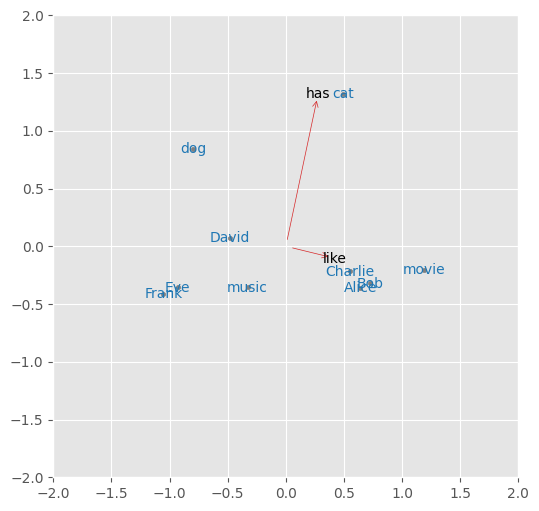

In [11]:
# Get the entity and relation embeddings
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
plt.style.use('ggplot')

entitie_list=list(triples_factory.entity_to_id.keys())
relation_list =list(triples_factory.relation_to_id.keys())

entity_embeddings = model.get_embeddings(
       entitie_list,
        embedding_type='e'
    )
relation_embeddings = model.get_embeddings(
        relation_list, 
        embedding_type='r'
    )

# Perform PCA on the embeddings
pca = PCA(n_components=2)
m = pca.fit(entity_embeddings)

# Plot the embeddings
eu = m.transform(entity_embeddings)
plt.figure(figsize=(6, 6))

plt.scatter(eu[:, 0], eu[:, 1], color='gray',marker='.')
for i, entity in enumerate(entitie_list):
#     plt.annotate(entity, (eu[i, 0], eu[i, 1]))
    plt.annotate(
        text=entity,
        xy=(eu[i, 0], eu[i, 1]),
        color="tab:blue",
        ha="center", va="center"
    )

ru = m.transform(relation_embeddings)    
# plt.scatter(ru[:, 0], ru[:, 1], color='red')
for i, relation in enumerate(relation_list):
#     plt.annotate(relation, (ru[i, 0], ru[i, 1]))
    plt.annotate(
        text=relation,
        xy=(0,0), xytext=(ru[i, 0], ru[i, 1]),
        arrowprops=dict(
            arrowstyle="<-",
            color="tab:red",
            shrinkA=5,
            shrinkB=5,
            patchA=None,
            patchB=None,
            connectionstyle="arc3,rad=0."
        )
    )

    
plt.xlim([-2, 2])
plt.ylim([-2, 2])

plt.show()